In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from fbprophet import Prophet
from matplotlib import pyplot as plt
import time
from datetime import datetime as dt
from datetime import timedelta as td

In [2]:
class Predictor():
    def __init__(self, currency, training_days, test_days):
        self.currency = currency
        self.training_days = training_days
        self.test_days = test_days
        self.model = Prophet(yearly_seasonality=False, daily_seasonality=False)
        assert type(self.currency) == str
    
    def __len__(self):
        return self.training_days + self.test_days

    def make_model(self):
        
        # Set date ranges to collect training and test data from CoinMarketCap
        test_end = dt.today()
        test_start = test_end - td(days=self.test_days-1)
        training_end = test_start - td(days=1)
        training_start = test_start - td(days=self.training_days)

        test_end = test_end.strftime("%Y%m%d")
        test_start = test_start.strftime("%Y%m%d")
        training_end = training_end.strftime("%Y%m%d")
        training_start = training_start.strftime("%Y%m%d")
        
        
        # Read table from historical data page of cryptocurrency
        market_info_test = pd.read_html("https://coinmarketcap.com/currencies/" + self.currency + "/historical-data/?start=" + test_start + "&end=" + test_end)[0]
        market_info_test.drop(market_info_test.columns[[1, 2, 3, 5, 6]], axis=1, inplace=True)
        market_info_test = market_info_test.assign(Date=pd.to_datetime(market_info_test['Date']))
        market_info_test.columns = ['ds', 'y']
        market_info_test['y'] = np.log(market_info_test['y'])
        self.test = market_info_test.iloc[::-1].sort_index(axis=0 ,ascending=False)

        market_info_training = pd.read_html("https://coinmarketcap.com/currencies/" + self.currency + "/historical-data/?start=" + training_start + "&end=" + training_end)[0]
        market_info_training.drop(market_info_training.columns[[1, 2, 3, 5, 6]], axis=1, inplace=True)
        market_info_training = market_info_training.assign(Date=pd.to_datetime(market_info_training['Date']))
        market_info_training.columns = ['ds', 'y']
        market_info_training['y'] = np.log(market_info_training['y'])
        self.training = market_info_training.iloc[::-1].sort_index(axis=0 ,ascending=False)
        
        
        # Fit training data to model and eval speed
        print("Fitting training data...")
        start = time.time()
        self.model.fit(self.training)
        print("Took", round(time.time()-start, 4), "seconds.", "\n")
        
        
        # Evaluate model by calculating Mean Absolute Error of predictions 
        # for test days with actual prices on those days
        print("Evaluating model on testing data...")
        future = self.model.make_future_dataframe(periods=self.test_days)
        forecast = self.model.predict(future)
        forecast = forecast[-self.test_days:]
        
        revert = lambda x: np.e**x
        forecast['yhat'] = forecast['yhat'].apply(revert)
        forecast['yhat_upper'] = forecast['yhat_upper'].apply(revert)
        forecast['yhat_lower'] = forecast['yhat_lower'].apply(revert)
        self.error_forecast = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
        test = self.test.copy(deep=True)['y'].apply(revert)
        
        # print(len(forecast), len(test))
        if not all([x==y for x, y in zip(forecast['ds'], self.test['ds'])]):
            raise ValueError("Test or Forecast Dataframe isn't ordered by date or order is mismatched")
        self.mae_upper = sum([abs(yhat - y) for yhat, y in zip(forecast['yhat_upper'], test)]) / len(forecast)
        self.mae = sum([abs(yhat - y) for yhat, y in zip(forecast['yhat'], test)]) / len(forecast)
        self.mae_lower = sum([abs(yhat - y) for yhat, y in zip(forecast['yhat_lower'], test)]) / len(forecast)
        print("Upper MAE: $" + str(self.mae_upper))
        print("MAE: $" + str(self.mae))
        print("Lower MAE: $" + str(self.mae_lower) + "\n")
    
    def predict(self, days, make_plot=True):
        # Reinitialize model and fit both training and test 
        # data to create most up-to-date model
        self.model = Prophet(yearly_seasonality=False, daily_seasonality=False)
        print("Fitting all data...")
        start = time.time()
        self.model.fit(pd.concat([self.test, self.training]))
        print("Took", round(time.time()-start, 4), "seconds.")
        
        future = self.model.make_future_dataframe(periods=days)
        self.forecast = self.model.predict(future)
        
        revert = lambda x: np.e**x
        self.model.history['y'] = self.model.history['y'].apply(revert)
        self.forecast['yhat'] = self.forecast['yhat'].apply(revert)
        self.forecast['yhat_upper'] = self.forecast['yhat_upper'].apply(revert)
        self.forecast['yhat_lower'] = self.forecast['yhat_lower'].apply(revert)
        
        # Plot forecast and actual data if plotting desired
        if make_plot: return self.model.plot(self.forecast), self.model.plot_components(self.forecast)
        

Fitting training data...
Took 0.4277 seconds. 

Evaluating model on testing data...
Upper MAE: $1410.37721201
MAE: $349.354772301
Lower MAE: $2116.24556621

Fitting all data...
Took 0.5419 seconds.


(<matplotlib.figure.Figure at 0x10b3f42b0>,
 <matplotlib.figure.Figure at 0x114170c88>)

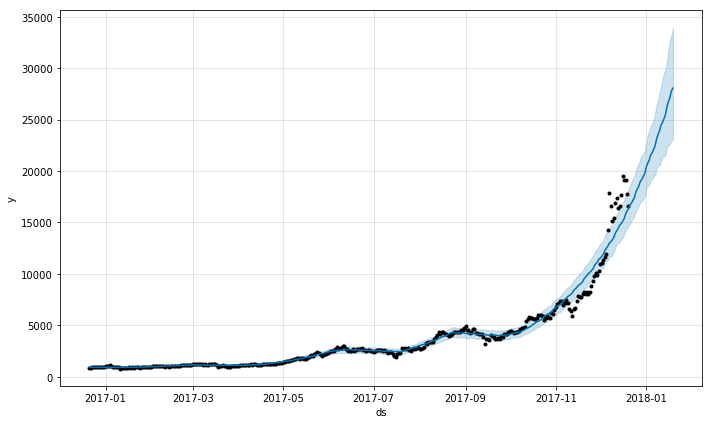

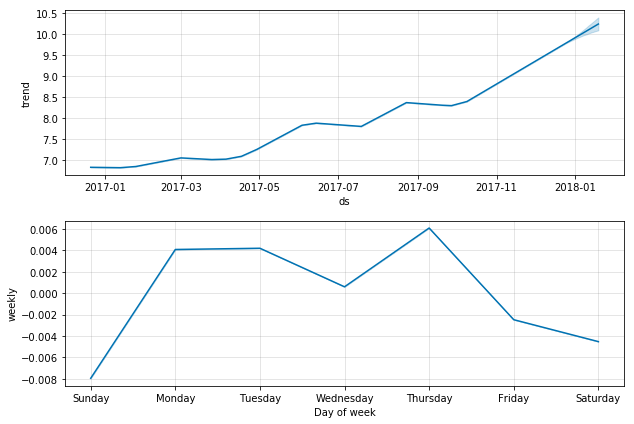

In [3]:
# Init predictor object for bitcoin with 364 training days and 1 test day. 
# This around the time when BTC began showing its infamous volatility levels.
bitcoin_predictor = Predictor("bitcoin", 364, 1)

# Assemble model
bitcoin_predictor.make_model()

# Predict the next 30 days worth of prices
bitcoin_predictor.predict(30)

In [4]:
bitcoin_predictor.error_forecast.head()

,ds,yhat,yhat_upper,yhat_lower
364,2017-12-20,16275.245228,18034.977212,14508.354434


In [5]:
bitcoin_predictor.test['y'] = bitcoin_predictor.test['y'].apply(lambda x: np.e**x)
bitcoin_predictor.test.head()

,ds,y
0,2017-12-20,16624.6


If you play around with the number of training days and test days in the predictor object, you can see that the MAE is almost arbitrary. It may seem that way but this volatility may be because of the constant changes that the Bitcoin market is going through. Basically, Bitcoin is EXTREMELY unpredictable. At most, we can loosely predict tomorrow's closing price based on a training period representative of the current price volatility.